In [ ]:
# This notebook is intended to generate alt text image descriptions
# from a metadata file and a folder containing a set of images, using
# versions of the Qwen2.5-VL vision-language model. It is adapted from
# https://huggingface.co/Ertugrul/Qwen2-VL-7B-Captioner-Relaxed
# Inference can run on CPU, CUDA or Apple MLX (your mileage may vary).

In [ ]:
import csv
import glob
import re
import string

import pandas as pd
import torch
import yaml
from datasets import Dataset
from PIL import Image
from qwen_vl_utils import process_vision_info
from tabulate import tabulate
from transformers import (
    AutoProcessor,
    Qwen2_5_VLForConditionalGeneration,
)

# For Apple ARM/MLX
if torch.backends.mps.is_available():
    from mlx_vlm import generate, load
    from mlx_vlm.prompt_utils import apply_chat_template
    from mlx_vlm.utils import load_config

    # model_id = "mlx-community/Qwen2.5-VL-7B-Instruct-8bit"
    # We'll use a cloned version of the model with a slightly tweaked processor_config.json file
    # instead, due to a bug that causes the MLX-LVM version of the model to inherit a bad setting.
    # Hopefully this bug eventually will be fixed in the upstream version.
    # Specifically, the "image_processor_type" should be "Qwen2VLImageProcessor"
    # ("AutoImageProcessor" probably would work, too) instead of "Qwen2_5_VLImageProcessor"
    # (see https://huggingface.co/Qwen/Qwen2.5-VL-7B-Instruct/discussions/24)
    model_id = "broadwell/Qwen2.5-VL-7B-Instruct-8bit-fixed-config"
    torch.set_default_device("mps:0")
    device = "mps:0"
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_id = "Qwen/Qwen2.5-VL-7B-Instruct"

# A metadata file, a folder containing all of the images to be captioned, and optionally
# a YAML file containing a system prompt and a template for a per-item prompt (which can
# be filled in with fields from the metadata file) should be provided according to this
# template. Output files also will be named according to the project handle.
PROJECT_HANDLE = "japanese_loc"
metadata_file_glob = f"metadata/{PROJECT_HANDLE}*"
prompt_file_glob = f"prompts/{PROJECT_HANDLE}*.yaml"
# images_dir = f"../{PROJECT_HANDLE}/"
images_dir = "../ma/japanese_images/"

# The metadata file can be tab-separated (.txt) or comma-separated (.csv)
# Every line must contain the following:
# - filename (the path to the image file)
# - caption (the original caption of the image; can be an empty string)
# - permalink (link to the image's original page; can be an empty string)
# - place (the place associated with the image; can be an empty string)
# - date (can be an empty string)
# If the metadata includes an *image_url* column, this is used in place of the
# local *filename* field to display the image in the HTML of the results table

SYSTEM_BASE = """You are a Vision Language Model specialized in generating descriptive alt text for images on websites.
Your task is to analyze the provided image and produce a concise description of the image, based on the visual information in the image and any additional data provided in the prompt."""

if glob.glob(prompt_file_glob):
    with open(glob.glob(prompt_file_glob)[0]) as prompt_file:
        prompt_data = yaml.safe_load(prompt_file)
        base_prompt = prompt_data["template"]
        system_message = SYSTEM_BASE + "\n" + prompt_data["system"]
else:
    base_prompt = "Please write a caption in English for this image that can be used as alt text on a website. The caption should be at most 150 characters long and preferably not more than 125 characters long."
    system_message = SYSTEM_BASE

prompt = (
    base_prompt
    + " Please do not mention proper names (persons, locations) unless they are included in the following information, which you may use when writing the text: "
)
unprompt = (
    base_prompt
    + " Please do not mention proper names (persons, locations) unless contained in the picture itself."
)

MAX_RECORDS = -1  # Set to -1 to process all records

In [8]:
prompted_inputs = []
unprompted_inputs = []

metadata_csv = glob.glob(metadata_file_glob)[0]

with open(metadata_csv, mode="r", encoding="utf-8") as data_file:
    if metadata_csv.endswith(".csv"):
        csvFile = csv.DictReader(data_file)
    else:
        csvFile = csv.DictReader(data_file, delimiter="\t", quoting=csv.QUOTE_NONE)
    for l, line in enumerate(csvFile):
        if MAX_RECORDS > 0 and l >= MAX_RECORDS:
            break
        extra_metadata = []
        if line["place"].strip() != "":
            extra_metadata.append(
                "The location of the image is " + line["place"].strip() + "."
            )
        if line["date"].strip() != "":
            extra_metadata.append(
                "The approximate date of the image is " + line["date"].strip() + "."
            )
        if line["caption"].strip() != "":
            extra_metadata.append(
                "A factual description of the image is the following: "
                + line["caption"].strip()
            )

        prompt = prompt + " ".join(extra_metadata)

        desc = line["caption"]

        img = Image.open(images_dir + "/" + line["filename"].replace("tif", "jpg"))

        prompted_inputs.append(
            {
                "file": line["filename"],
                "image": img.copy(),
                "query": prompt,
                "label": [desc.strip()],
            }
        )
        unprompted_inputs.append(
            {
                "file": line["filename"],
                "image": img.copy(),
                "query": unprompt,
                "label": [desc.strip()],
            }
        )

        img.close()

In [9]:
if metadata_csv.endswith(".csv"):
    df = pd.read_csv(metadata_csv, sep=",")
else:
    df = pd.read_csv(metadata_csv, sep="\t")

In [10]:
def format_data(sample):
    return [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_message}],
        },
        {
            "role": "user",
            "content": [
                {"type": "image", "image": sample["image"]},
                {"type": "text", "text": sample["query"]},
            ],
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": sample["label"][0]}],
        },
        {
            "role": "metadata",
            "content": [{"type": "text", "text": sample["file"]}],
        },
    ]

In [11]:
prompted_dataset = [
    format_data(sample) for sample in Dataset.from_list(prompted_inputs)
]
unprompted_dataset = [
    format_data(sample) for sample in Dataset.from_list(unprompted_inputs)
]

In [12]:
# A sample of the conditioned prompt data:
prompted_dataset[6]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': "You are a Vision Language Model specialized in generating descriptive alt text for images on websites.\nYour task is to analyze the provided image and produce a concise description of the image, based on the visual information in the image and any additional data provided in the prompt.\nDo not provide any critical or positive evaluation of the image and its aesthetic qualities. Avoid using vague words such as 'traditional', 'ornate', 'elaborate' to describe cultural, historical or aesthetic aspects of the image. Do not provide the names of people, places or works of art related to the image unless they are present in the prompt."}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=504x640>},
   {'type': 'text',
    'text': "Please write a caption in English for this image that can be used as alt text on a website and is at most 125 characters long. Please

In [13]:
# A sample of the "unconditioned" prompt data:
unprompted_dataset[6]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': "You are a Vision Language Model specialized in generating descriptive alt text for images on websites.\nYour task is to analyze the provided image and produce a concise description of the image, based on the visual information in the image and any additional data provided in the prompt.\nDo not provide any critical or positive evaluation of the image and its aesthetic qualities. Avoid using vague words such as 'traditional', 'ornate', 'elaborate' to describe cultural, historical or aesthetic aspects of the image. Do not provide the names of people, places or works of art related to the image unless they are present in the prompt."}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=504x640>},
   {'type': 'text',
    'text': "Please write a caption in English for this image that can be used as alt text on a website and is at most 125 characters long. Please

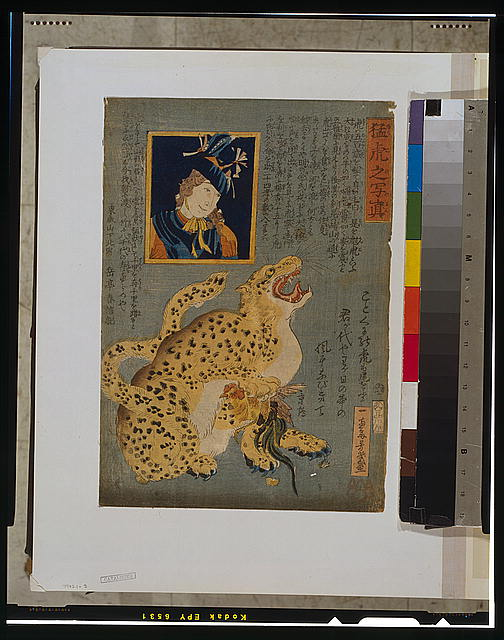

In [14]:
# An image in the input to the captioning model
prompted_dataset[6][1]["content"][0]["image"]

In [15]:
if torch.backends.mps.is_available():
    model, processor = load(model_id)
    config = load_config(model_id)
else:
    model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
        model_id, torch_dtype=torch.bfloat16, device_map="auto"
    )
    processor = AutoProcessor.from_pretrained(model_id)
    config = None

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


PROCESSOR PATH /Users/pmb/.cache/huggingface/hub/models--broadwell--Qwen2.5-VL-7B-Instruct-8bit-fixed-config/snapshots/652d5bd03cd7f02f3f58c768cd8a119d919b5a54 KWARGS {}


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

In [16]:
def generate_text_from_sample(
    model,
    processor,
    sample,
    device="cuda",
    config=None,
    max_new_tokens=1024,
):
    if device == "mps:0":
        images = [images_dir + "/" + sample[3]["content"][0]["text"]]
        formatted_prompt = apply_chat_template(
            processor, config, sample[:2], num_images=len(images)
        )
        output = generate(model, processor, formatted_prompt, images, verbose=False)

        return output

    else:
        # Prepare the text input by applying the chat template
        text_input = processor.apply_chat_template(
            sample[
                :2
            ],  # 1:2 would be just the sample (and prompt) without the system message
            tokenize=False,
            add_generation_prompt=True,
        )

        # Process the visual input from the sample
        image_inputs, _ = process_vision_info(sample)

        # Prepare the inputs for the model
        model_inputs = processor(
            text=[text_input],
            images=image_inputs,
            return_tensors="pt",
        ).to(device)  # Move inputs to the specified device

        # Generate text with the model
        generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

        # Trim the generated token ids to remove the input ids
        trimmed_generated_ids = [
            out_ids[len(in_ids) :]
            for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)
        ]

        # Decode the output text
        output_text = processor.batch_decode(
            trimmed_generated_ids,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=False,
        )

        return output_text[0]  # Return the first decoded output text

In [ ]:
captioning_results = open(f"{PROJECT_HANDLE}_captions.txt", "w", encoding="utf-8")

captioning_results.write(
    "\t".join(["filename", "path", "permalink", "human", "collaborative", "model"])
    + "\n"
)

for i, item in enumerate(unprompted_dataset):
    output = (
        generate_text_from_sample(model, processor, prompted_dataset[i], device, config)
        .replace('"', "")
        .replace("\n", " ")
        .replace("\t", " ")
    )
    imageonlyoutput = (
        generate_text_from_sample(model, processor, item, device, config)
        .replace('"', "")
        .replace("\n", " ")
        .replace("\t", " ")
    )
    filename = item[3]["content"][0]["text"]
    record = df[df["filename"] == filename]
    desc = item[2]["content"][0]["text"].replace("\n", " ").replace("\t", " ")
    print(
        f"{filename} | {desc} | {output} ({str(len(output))} chars) | {imageonlyoutput} ({str(len(imageonlyoutput))} chars)"
    )
    if "image_url" in df.columns:
        path = record["image_url"].item()
    else:
        path = "images/" + filename.replace("tif", "jpg")

    captioning_results.write(
        "\t".join(
            [filename, path, record["permalink"].item(), desc, output, imageonlyoutput]
        )
        + "\n"
    )

captioning_results.close()

2002700113.jpg | Japanese print shows activities including: tilling soil, poling boats, talking, riding on horseback, and riding in a rickshaw. | Japanese print depicting activities such as tilling soil, poling boats, and riding on horseback and in a rickshaw. (114 chars) | A traditional Japanese scene with figures near a bridge and a horse-drawn cart. (79 chars)
2002700349.jpg | Japanese print shows an American military officer (probably Captain Henry Adams). | Japanese print depicting a military officer with a sword, 1854. (63 chars) | Traditional Japanese woodblock print of a warrior in armor, holding a sword. (76 chars)
2002700239.jpg | Japanese triptych print shows visitors from several nations enjoying a party in the Fan Room of the Gankirō. | Japanese print depicting people engaging in various activities, including tilling soil, poling boats, and riding in a rickshaw, dated 1854. (139 chars) | A traditional Japanese woodblock print depicting a woman in a colorful kimono and two 

KeyboardInterrupt: 

In [ ]:
presentation_results = []

human_color = "blue"
model_color = "red"
combined_color = "purple"


# Remove punctuation from a word
def clean_word(word):
    return "".join([char.lower() for char in word if char not in string.punctuation])


# Remove punctuation from all words in a list and return the "cleaned" words as a set
def get_clean_words(words):
    clean = set()
    for word in words:
        term = clean_word(word)
        clean.add(term)
    return clean


def colorize_string(s, human_terms, model_terms, combined_terms):
    colorized_words = []
    for word in re.split("[- :\s]", s):
        clean = clean_word(word)
        word_color = None
        if clean.lower() in combined_terms:
            word_color = combined_color
        elif clean.lower() in human_terms:
            word_color = human_color
        elif clean.lower() in model_terms:
            word_color = model_color

        if word_color is not None:
            colorized_words.append(f"<span style='color: {word_color}'>{word}</span>")
        else:
            colorized_words.append(word)
    return " ".join(colorized_words)


with open(
    f"{PROJECT_HANDLE}_captions.txt", "r", encoding="utf-8"
) as captioning_results:
    for line in captioning_results:
        filename, path, permalink, desc, output, imageonlyoutput = line.strip().split(
            "\t"
        )
        if filename == "filename":
            continue

        human_terms = get_clean_words(re.split("[- :\s]", desc))
        model_terms = get_clean_words(re.split("[- :\s]", imageonlyoutput))
        combined_terms = human_terms.intersection(model_terms)

        human_colorized = f"<span style='color: {human_color}'>{desc}</span>"
        model_colorized = f"<span style='color: {model_color}'>{imageonlyoutput}</span>"
        combined_colorized = colorize_string(
            output, human_terms, model_terms, combined_terms
        )

        presentation_results.append(
            {
                "Image": '<a target="_blank" href="'
                + permalink
                + '"> <img style = "width:400px;" src="'
                + path
                + '"/ ></a>',
                "Original Caption": f"🧑‍🏫 {human_colorized}",
                "Collaborative Caption": f"🤖🤝🧑‍🏫 {combined_colorized} ({str(len(output))} chars)",
                "Qwen2.5-VL-7B": f"🤖 {model_colorized} ({str(len(imageonlyoutput))} chars)",
            }
        )

presentation_df = pd.DataFrame(presentation_results)
results_table = tabulate(presentation_df, tablefmt="unsafehtml", headers="keys")
print(results_table)
results_html = f"""
<!DOCTYPE html>
<html>
  <head>
    <meta charset="UTF-8">
    <style>
      img {{
        width: 200px; 
        height: 400px; 
        object-fit: contain;
      }}
      table, th, td {{
        border: 1px solid;
      }}
    </style>
  </head>
{results_table}
</html>
"""
with open(f"{PROJECT_HANDLE}.html", "w", encoding="utf-8") as html_results:
    html_results.write(results_html)

<table>
<thead>
<tr><th style="text-align: right;">   </th><th>Image                                                                                                                                                                                              </th><th>Original Caption                                                                                                                                                                                                                                                                                                                                                                      </th><th>Collaborative Caption                                                                                                                                                                                                                                                                                                                                         